 **PA005: High Value Customers Identification (Insiders)**

In [1]:
import re

import pandas as pd
import seaborn as sns
import numpy as np
import umap.umap_ as umap


from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly              import express       as px 
from sklearn             import cluster       as c 
from sklearn             import metrics       as m
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import ensemble      as en
from matplotlib          import pyplot        as plt 
from sklearn.manifold    import TSNE
from sklearn             import manifold      as mn
from sklearn             import mixture       as mx
from sklearn.neighbors   import NearestNeighbors
from scipy.cluster       import hierarchy     as hc

import pickle
import s3fs
import os

/home/daniel/miniconda3/envs/ds_em_clusterizacao/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(os.environ)

environ({'SHELL': '/bin/bash', 'SESSION_MANAGER': 'local/daniel-Aspire-F5-573G:@/tmp/.ICE-unix/2021,unix/daniel-Aspire-F5-573G:/tmp/.ICE-unix/2021', 'QT_ACCESSIBILITY': '1', 'COLORTERM': 'truecolor', 'PYENV_SHELL': 'bash', 'XDG_CONFIG_DIRS': '/etc/xdg/xdg-ubuntu:/etc/xdg', 'SSH_AGENT_LAUNCHER': 'openssh', 'XDG_MENU_PREFIX': 'gnome-', 'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated', 'CONDA_EXE': '/home/daniel/miniconda3/bin/conda', '_CE_M': '', 'LC_ADDRESS': 'pt_BR.UTF-8', 'GNOME_SHELL_SESSION_MODE': 'ubuntu', 'LC_NAME': 'pt_BR.UTF-8', 'SSH_AUTH_SOCK': '/run/user/1000/openssh_agent', 'XMODIFIERS': '@im=ibus', 'DESKTOP_SESSION': 'ubuntu', 'LC_MONETARY': 'pt_BR.UTF-8', 'GTK_MODULES': 'gail:atk-bridge', 'PWD': '/home/daniel', 'PYENV_VIRTUALENV_INIT': '1', 'LOGNAME': 'daniel', 'XDG_SESSION_DESKTOP': 'ubuntu', 'XDG_SESSION_TYPE': 'wayland', 'CONDA_PREFIX': '/home/daniel/miniconda3/envs/ds_em_clusterizacao', 'SYSTEMD_EXEC_PID': '2044', 'XAUTHORITY': '/run/user/1000/.mutter-Xwaylandauth.N1GK1

In [2]:
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID_CDS_PROJETOS')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY_CDS_PROJETOS')

## Load data

In [3]:
path = '../data/raw/ecommerce.csv'

df_raw = pd.read_csv (path)

## Data Cleaning

In [4]:
df = df_raw.copy()

df = df.drop(columns=['Unnamed: 8'], axis=1)

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# <span style="color: OrangeRed;">DATA DESCRIPTION</span>
<span style="color: OrangeRed;">***PASSO 1***</span>

In [6]:
df1 = df.copy()

## Columns Description

|column|description|
|:-----|:---------|
|invoice_no|identificador de uma compra realizada no ecommerce|
|stock_code|identificador unico do produto comprado|
|description|descricao do produto|
|quantity|quantidade|
|invoice_date|data da compra|
|unit_price|preço unitario do produto|
|customer_id|identificador do comprador|
|country|pais do comprador|

## Rename Columns

In [7]:
new_columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = new_columns

## Data Dimensions

In [8]:
print('Number of rows:{}'.format(df1.shape[0]))
print('Number of rows:{}'.format(df1.shape[1]))

Number of rows:541909
Number of rows:8


## Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [11]:
# === customer_id ===
# df1 = df1.dropna(subset=['customer_id'],axis=0)
# print('Removed data from subset customer_id: {:.2f}%'.format(100*(1-(df1.shape[0]/df_raw.shape[0]))))

# df separando missing e nao-missing
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]
 
# selecionando invoice do missing no nao-missing, para encontrar correspondencia de customer_id
# df_not_missing.loc[df_not_missing['invoice_no'].isin(df_missing['invoice_no']), :] #Out: []

# Ultimo valor de de customer_id
# df1['customer_id'].max() #Out: 18287

# table of unique invoice that has customer_id missing
invoice_missing = pd.DataFrame(df_missing['invoice_no'].drop_duplicates()).reset_index(drop=True)

# Vector of values to assume sintetic 'customer_id' values
invoice_missing['customer_id'] = np.arange(19000, (19000 + len(invoice_missing)), 1)

# Merge to add sintetic values to orginal dataframe
df1 = pd.merge(df1, invoice_missing, on='invoice_no', how='left')

# Combine to aggregate into unique customer_id column
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)

# ===description=== 
df1['description'] = df1['description'].fillna(0)

#Print missings 
df1.head()
print('\033[1mMissing values:\033[0m \n\n{}'.format(df1.isna().sum()))


Missing values: 

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64


## Change Dtypes

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [13]:
# invoice_date     
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.strftime('%Y-%m-%d')
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

# customer_id     
df1['customer_id'] = df1['customer_id'].astype(int)

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [14]:
# Central Tendency - mean, median
c1 = pd.DataFrame(num_attributes.mean()).T
c2 = pd.DataFrame(num_attributes.median()).T

# Dispersion - min, max, range, std, skew, kurtosis
d1 = pd.DataFrame(num_attributes.min()).T
d2 = pd.DataFrame(num_attributes.max()).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.std())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

descriptive_analysis = pd.concat([ d1, d2, d3, c1, d4, c2, d5, d6], axis= 0).T.reset_index()
descriptive_analysis.columns = ['attributes','min','max', 'range','mean','std', 'median', 'skew', 'kurtosis']
descriptive_analysis

,attributes,min,max,range,mean,std,median,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,218.081158,3.00,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,96.759853,2.08,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,2911.411352,16249.00,0.487449,-0.804287


### Categorical Attributes

In [16]:
cat_attributes.head()


,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Categorical attributes - Investigating

##### Invoice no

In [17]:
# problema: invoices com letras e numeros
# df1['invoice_no'].astype(int)

# identificacao:  counting anomalous invoice_no with a letter at beginning
contain_letter = df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x)))
unique_invoice_letter = df1.loc[contain_letter,'invoice_no']
print('invoice_no unicos que contem letras: {}'.format(unique_invoice_letter.drop_duplicates().count()))
print('invoice_no unicos: {}'.format(df1['invoice_no'].unique().shape[0]))
print('Linhas com invoices com letra no inicio: {}'.format(unique_invoice_letter.count()))
print('Linhas com quantidades < 0: {}'.format(df1.loc[df1['quantity']<0,'invoice_no'].count()))

invoice_no unicos que contem letras: 3839
invoice_no unicos: 25900
Linhas com invoices com letra no inicio: 9291
Linhas com quantidades < 0: 10624


In [18]:
unique_invoice_letter


141       C536379
154       C536383
235       C536391
236       C536391
237       C536391
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: invoice_no, Length: 9291, dtype: object

##### Stock code

In [19]:
# stock_code that contain letter
contain_letter = df1['stock_code'].apply(lambda x: bool(re.search('[^0-9]+',x)))
unique_stock_letter = df1.loc[contain_letter,'stock_code'].drop_duplicates()
print('stock_code unicos com alguma letra: {}'.format(unique_stock_letter.count()))

# unique stock_code all letter
all_letters = df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x)))
unique_stock_all_letter = df1.loc[all_letters,'stock_code'].drop_duplicates()
print('stock_code que contem apenas letras: {}'.format(unique_stock_all_letter.count()))
print('stock code all letters: {}'.format(unique_stock_all_letter.unique()))

# identificação: linhas com stock_code somente letras 
df1.loc[df1['stock_code'].isin(unique_stock_all_letter)]

stock_code unicos com alguma letra: 1124
stock_code que contem apenas letras: 12
stock code all letters: ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001
...,...,...,...,...,...,...,...,...
541540,581498,DOT,DOTCOM POSTAGE,1,2017-12-07,1714.17,United Kingdom,22709
541541,C581499,M,Manual,-1,2017-12-07,224.69,United Kingdom,15498
541730,581570,POST,POSTAGE,1,2017-12-07,18.00,Germany,12662
541767,581574,POST,POSTAGE,2,2017-12-07,18.00,Germany,12526


**Ação de limpeza:** dado que nao tenho conhecimento sobre esses valores com apenas letras, vou excluir nessa iteração

##### Description

In [20]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


**Ação:** enquanto nao sei como usar essa coluna para gerar alguma informação, vou exclui-la 

##### Country

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

Pontos que merecem atencao:<br>

- United Kingdom corresponde a quase todo dataset
- European Community aparece mesmo que os paises que se incluem nela aparecem separados 
- Unspecified

In [22]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [23]:
# customers per country
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id',ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# <span style="color: OrangeRed;">DATA FILTERING</span>
<span style="color: OrangeRed;">***PASSO 2*** </span>

In [16]:
df2 = df1.copy()

In [17]:
# === Categorical attributes === 
# stock_code
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS','B', 'CRUK'])]

# description
df2 = df2.drop(columns = ['description'], axis=1)

#country
df2 = df2.loc[~df2['country'].isin(['Unspecified','European Community']), :]

# bad customers
df2 = df2[~df2['customer_id'].isin([16446]) ]


# === Numerical attributes === 
# unit_price above 0.01
df2 = df2.loc[df2['unit_price']>0.01]

# quantity
df_returns = df2.loc[df2['quantity']<0]
df_purchase = df2.loc[df2['quantity']>0]





# <span style="color: OrangeRed;">FEATURE ENGINEERING</span>
<span style="color: OrangeRed;">***PASSO 3***</span>

In [18]:
df3 = df2.copy()

## Feature Creation

In [19]:
# dataframe of unique 'customer_id' to be merged with
df_customers = df2.drop(columns= ['invoice_no', 'stock_code', 'quantity', 'invoice_date',
                                  'unit_price', 'country'],axis=1).drop_duplicates(ignore_index=True)

### Monetary - gross revenue by customers

In [20]:
# monetary or LTV - gross revenue/customer
df_purchase['gross_revenue'] = df_purchase['unit_price']*df_purchase['quantity']
df_monetary = df_purchase.groupby('customer_id')['gross_revenue'].sum().reset_index()
df_monetary = df_monetary.rename(columns = {'gross_revenue':'monetary'})

df_customers = pd.merge(df_customers,df_monetary, on='customer_id', how='left')
df_customers.isna().sum() # 91 linhas com quantity negativo 

/tmp/ipykernel_9062/3064971249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase['gross_revenue'] = df_purchase['unit_price']*df_purchase['quantity']


customer_id     0
monetary       91
dtype: int64

### Recency - days since last purchase

In [21]:
# recency - days since last purchase
df_recency = df_purchase.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency']]
df_recency.head()

df_customers = pd.merge(df_customers,df_recency, on='customer_id', how='left')
df_customers.head()
df_customers.isna().sum()

customer_id     0
monetary       91
recency        91
dtype: int64

### Frequency - purchases/day

In [22]:
# # frequency - purchases/month
# df_purchase['year_month'] = df_purchase['invoice_date'].dt.strftime('%Y-%m')
# df_frequency = df_purchase[['customer_id','year_month','invoice_no']].groupby(['customer_id','year_month']).nunique().reset_index()
# df_frequency = df_frequency.groupby('customer_id')['invoice_no'].mean().reset_index()
# df_frequency = df_frequency.rename (columns = {'invoice_no':'frequency'})
# df_frequency.head()

# df_customers = pd.merge(df_customers,df_frequency, on='customer_id', how='left')
# df_customers.head()
# df_customers.isna().sum()

In [23]:
# frequency - purchases/day
df_aux = (df_purchase[['invoice_no','customer_id','invoice_date']].drop_duplicates().groupby('customer_id')
                                                                           .aggregate (max_   = ('invoice_date','max'),
                                                                                       min_   = ('invoice_date','min'), 
                                                                                       period = ('invoice_date', lambda x: (x.max()-x.min()).days + 1),
                                                                                       invoice_no = ('invoice_no','count'))).reset_index()

df_aux['frequency'] = df_aux.apply(lambda x: x['invoice_no']/x['period'] if x['period']!=0 else 0, axis=1)

df_customers = pd.merge(df_customers, df_aux[['customer_id','frequency']], on='customer_id', how='left')
df_customers.isna().sum()

customer_id     0
monetary       91
recency        91
frequency      91
dtype: int64

### Quantity products - different stock_code by customer

In [24]:
df_products_purchased = df_purchase[['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'quantity_products'})
df_customers = pd.merge(df_customers,df_products_purchased, on='customer_id', how='left')
df_customers.isna().sum()

customer_id           0
monetary             91
recency              91
frequency            91
quantity_products    91
dtype: int64

### Returns - number of returns

In [25]:
# Number of returns 
df_returns = df_returns[['customer_id','quantity']].drop_duplicates().groupby('customer_id').sum().reset_index().rename(columns={'quantity':'returns'})
df_returns['returns'] = df_returns['returns']*(-1)
df_customers = pd.merge(df_customers, df_returns,how='left',on='customer_id')
df_customers.loc[df_customers['returns'].isna(),'returns'] = 0
df_customers.isna().sum()

# first_purchase_at - min invoice_date

customer_id           0
monetary             91
recency              91
frequency            91
quantity_products    91
returns               0
dtype: int64

In [26]:
### Quantity items - total quantity of items  
df_items_purchased = df_purchase[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'quantity_items'})
df_customers = pd.merge(df_customers,df_items_purchased, on='customer_id', how='left')
df_customers.isna().sum()

customer_id           0
monetary             91
recency              91
frequency            91
quantity_products    91
returns               0
quantity_items       91
dtype: int64

In [27]:
df_customers.shape

(5786, 7)

#  <span style="color: OrangeRed;">EXPLORATORY DATA ANALYSIS (EDA) PT1</span>
<span style="color: OrangeRed;">***PASSO 4*** </span>

In [38]:
df4 = df_customers.dropna().copy() 

In [39]:
df4.shape

(5695, 7)

## Estudo do espaço 

In [40]:
# selected dataset without avg features
cols_selected = ['customer_id','monetary', 'recency', 'frequency', 'quantity_products', 'returns']
df43 = df4[cols_selected].drop(columns = ['customer_id'],axis=1).copy()

In [31]:
# MinMax Scaler
mms_monetary = pp.MinMaxScaler()
mms_recency = pp.MinMaxScaler()
mms_frequency = pp.MinMaxScaler()
mms_quantity_products = pp.MinMaxScaler()
mms_returns = pp.MinMaxScaler()

#save to S3
fs = s3fs.S3FileSystem(anon=False, key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY)


# Apply scalers
df43['monetary']              = mms_monetary.fit_transform(df43[['monetary']])
# pickle.dump(mms_monetary, open('../src/features/monetary_scaler.pkl','wb'))
pickle.dump(mms_monetary, fs.open('s3://insiders-dhrt-dataset/monetary_scaler.pkl','wb'))

df43['recency']                = mms_recency.fit_transform(df43[['recency']])
# pickle.dump(mms_recency, open('../src/features/recency_scaler.pkl','wb'))
pickle.dump(mms_recency, fs.open('s3://insiders-dhrt-dataset/recency_scaler.pkl','wb'))

df43['frequency']              = mms_frequency.fit_transform(df43[['frequency']])
# pickle.dump(mms_frequency, open('../src/features/frequency_scaler.pkl','wb'))
pickle.dump(mms_frequency, fs.open('s3://insiders-dhrt-dataset/frequency_scaler.pkl','wb'))

df43['quantity_products']      = mms_quantity_products.fit_transform(df43[['quantity_products']])
# pickle.dump(mms_quantity_products, open('../src/features/quantity_products_scaler.pkl','wb'))
pickle.dump(mms_quantity_products, fs.open('s3://insiders-dhrt-dataset/quantity_products_scaler.pkl','wb'))

df43['returns']                = mms_returns.fit_transform(df43[['returns']].values) 
# pickle.dump(mms_returns, open('../src/features/returns_scaler.pkl','wb'))
pickle.dump(mms_returns, fs.open('s3://insiders-dhrt-dataset/returns_scaler.pkl','wb'))

X = df43.copy()

### PCA

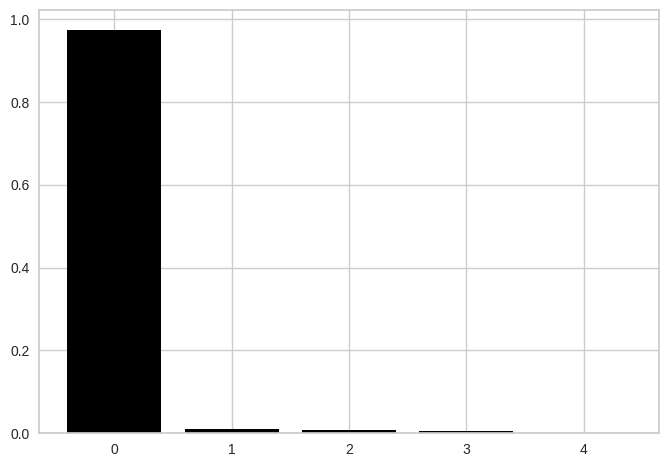

In [32]:
pca = dd.PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)

# pca reducer - pickle
# pickle.dump(pca, open('../src/features/pca_reducer.pkl','wb'))
pickle.dump(pca, fs.open('s3://insiders-dhrt-dataset/pca_reducer.pkl','wb'))


# plot
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# to dataframe
df_pca = pd.DataFrame(principal_components)

### UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

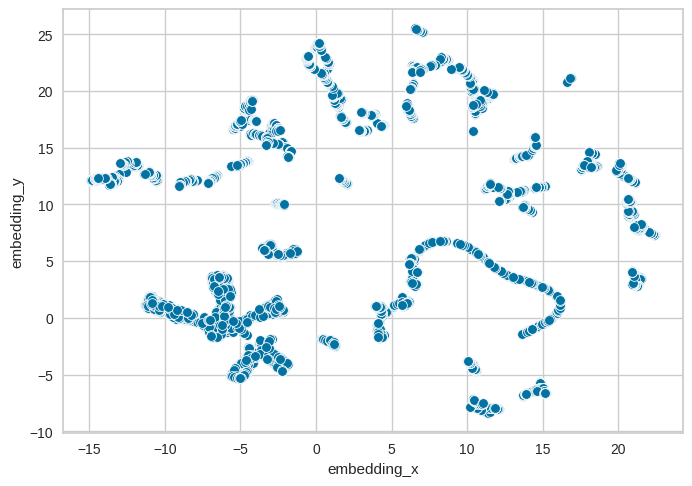

In [33]:
#UMAP
reducer = umap.UMAP (random_state=42) #n_neighbors quanto menor, ele foca mais nas estruturas locais em vez das globais
embedding = reducer.fit_transform (X) #espaço projetado após reducao de dimensionalidade

# umap reducer - pickle
pickle.dump(reducer, open('../src/features/umap_reducer.pkl','wb'))
pickle.dump(reducer, fs.open('s3://insiders-dhrt-dataset/umap_reducer.pkl','wb'))

#embedding
df_umap = pd.DataFrame()
df_umap ['embedding_x'] = embedding[:, 0]
df_umap ['embedding_y'] = embedding[:,1]

# plot embeding
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data = df_umap)



### t-sne

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

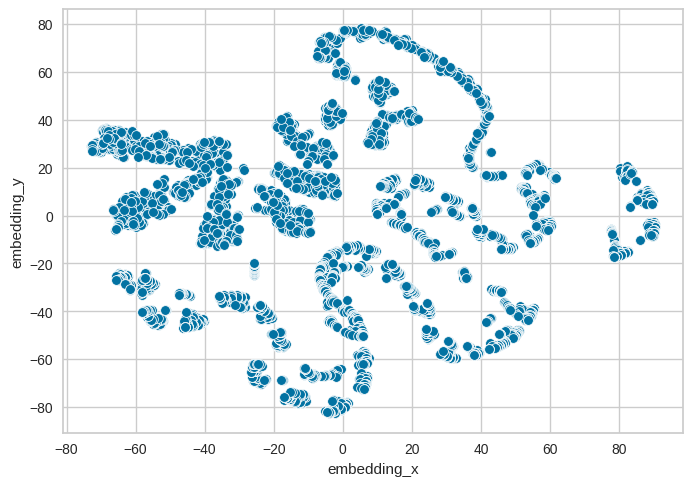

In [34]:
#t-sne
reducer = TSNE (n_components =2, 
                     n_jobs=-1,
                     random_state=42) #n_neighbors quanto menor, ele foca mais nas estruturas locais em vez das globais
embedding = reducer.fit_transform (X) #espaço projetado após reducao de dimensionalidade

# t-sne reducer - pickle
pickle.dump(reducer, open('../src/features/tsne_reducer.pkl','wb'))
pickle.dump(reducer, fs.open('s3://insiders-dhrt-dataset/tsne_reducer.pkl','wb'))

#embedding
df_tsne = pd.DataFrame()
df_tsne ['embedding_x'] = embedding[:, 0]
df_tsne ['embedding_y'] = embedding[:,1]

# plot embeding
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data = df_tsne)

### Tree based embeding

In [35]:
#Tree Based Embedding

# Training dataset
X = df43.drop(columns=['monetary'], axis=1)
y = df43['monetary']


# Model definition
rf_model = en.RandomForestRegressor(n_estimators = 1000, random_state=42)

# Model training
rf_model.fit (X, y)

# Pickle 
# pickle.dump(rf_model, open('../src/models/rf_model.pkl', 'wb'))
pickle.dump(rf_model, fs.open('s3://insiders-dhrt-dataset/rf_model.pkl','wb'))

# dataframe Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))



In [36]:
# UMAP Reducer for Tree Based Space
reducer = umap.UMAP (random_state=42) #n_neighbors quanto menor, ele foca mais nas estruturas locais em vez das globais
embedding = reducer.fit_transform (df_leaf) #espaço projetado após reducao de dimensionalidade

#embedding
df_tree = pd.DataFrame()
df_tree ['embedding_x'] = embedding[:, 0]
df_tree ['embedding_y'] = embedding[:,1]

/home/daniel/miniconda3/envs/ds_em_clusterizacao/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

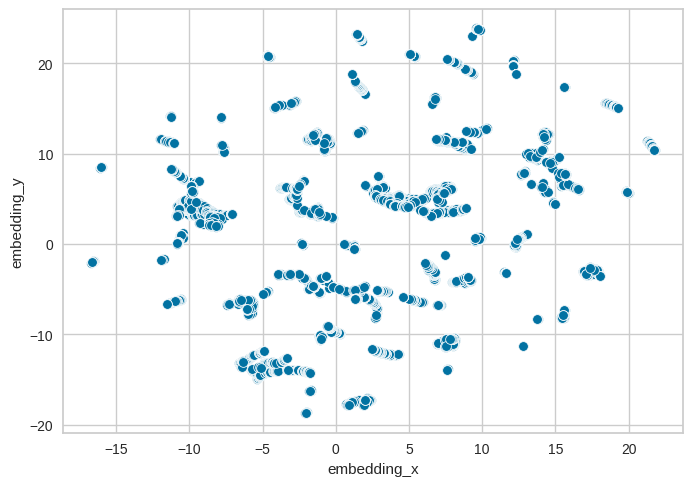

In [37]:
# plot embeding
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data = df_tree)


# <span style="color: OrangeRed;">FEATURE SELECTION</span>
<span style="color: OrangeRed;">***PASSO 6*** </span>

In [45]:
# Espaço de embedding - Tree Based 
df6 = df_tree.copy()

# <span style="color: OrangeRed;">MODEL TRAINING</span>
<span style="color: OrangeRed;">***PASSO 8***</span>

# Gaussian Mixture Model 

In [81]:
# k definition
k=8

# model name
gmm_model = mx.GaussianMixture (n_components = k, n_init= 300, random_state = 42)

# model training
gmm_model.fit(X)

# predict
labels = gmm_model.predict (X)  
    

## Cluster validation

In [82]:
# Silhoute Score
print('Silhouette Score: {}'.format (m.silhouette_score (X, labels, metric = 'euclidean')))

Silhouette Score: 0.05740500591888421


# <span style="color: OrangeRed;">CLUSTER ANALYSIS</span>
<span style="color: OrangeRed;">***PASSO 9***</span>

In [98]:
# tabela de customers_ com label do cluster
cols_selected = ['customer_id','monetary', 'recency', 'frequency', 'quantity_products', 'returns']
df92 = df4[cols_selected].copy()
df92['labels'] = labels.tolist()

## Cluster Profile

In [99]:
#change dtypes
df92['recency'] = df92['recency'].astype(int)
df92['quantity_products'] = df92['quantity_products'].astype(int)
df92['returns'] = df92['returns'].astype(int)

In [100]:
# Number of customers
df_cluster = df92[['customer_id', 'labels']].groupby('labels').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100


# Avg Monetary
df_avg_monetary = df92[['monetary','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, how='inner', on = 'labels')


# Avg  Recency 
df_avg_recency = df92[['recency','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on = 'labels')


# Avg Frequency
df_avg_frequency = df92[['frequency','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on = 'labels')


# Quantity products
df_quantity_products = df92[['quantity_products','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_quantity_products, how='inner', on = 'labels')


# Returns
df_returns = df92[['returns','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on = 'labels')

# Avg Ticket
# df_avg_ticket = df_aux[['labels','avg_ticket']].groupby('labels').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_avg_ticket,how ='inner', on='labels')

# Avg Basket
# df_avg_basket = df_aux[['labels','avg_basket']].groupby('labels').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_avg_basket,how ='inner', on='labels')

df_cluster

,labels,customer_id,perc_customer,monetary,recency,frequency,quantity_products,returns
0,0,612,22.069960,2834.181830,9.810458,0.041834,167.130719,5.697712
1,1,152,5.481428,1421.115329,114.861842,0.117163,125.092105,1.348684
2,2,1083,39.055175,1395.067295,33.306556,0.021256,71.188366,3.432133
3,3,601,21.673278,903.075408,142.489185,0.027789,39.216306,2.349418
4,4,23,0.829427,1370.011739,132.217391,1.609231,67.434783,5.173913
5,5,42,1.514605,47235.472857,4.904762,0.143803,1235.809524,283.976190
6,6,53,1.911287,9410.917736,105.641509,0.045841,78.339623,935.433962
7,7,207,7.464840,6623.161691,14.816425,0.044638,388.086957,46.685990


### Cluster Profile 

In [101]:
df_cluster

,labels,customer_id,perc_customer,monetary,recency,frequency,quantity_products,returns
0,0,612,22.069960,2834.181830,9.810458,0.041834,167.130719,5.697712
1,1,152,5.481428,1421.115329,114.861842,0.117163,125.092105,1.348684
2,2,1083,39.055175,1395.067295,33.306556,0.021256,71.188366,3.432133
3,3,601,21.673278,903.075408,142.489185,0.027789,39.216306,2.349418
4,4,23,0.829427,1370.011739,132.217391,1.609231,67.434783,5.173913
5,5,42,1.514605,47235.472857,4.904762,0.143803,1235.809524,283.976190
6,6,53,1.911287,9410.917736,105.641509,0.045841,78.339623,935.433962
7,7,207,7.464840,6623.161691,14.816425,0.044638,388.086957,46.685990


In [102]:
# Cluster Insider
# Cluster 
# Cluster
# Cluster
# Cluster
# Cluster
# Cluster
# Cluster

**Cluster 5 - Candidato a INSIDERS**
- Numero de customers: 355 (12.80%)
- Faturamento medio: $ 11,098
- Recencia media: 18 dias
- Media de produto: 485 produtos por compra
- Frequencia de compras por mes: 0.11 compras/dia
    
**Cluster 1 - ...**

# <span style="color: OrangeRed;">DEPLOY TO PRODUCTION </span>
<span style="color: OrangeRed;">***PASSO 11***</span>

In [103]:
df92.dtypes

customer_id            int64
monetary             float64
recency                int64
frequency            float64
quantity_products      int64
returns                int64
labels                 int64
dtype: object

## Insert into SQLITE

In [130]:
import sqlite3
from sqlalchemy import create_engine

In [123]:
text

<function sqlalchemy.sql._elements_constructors.text(text: 'str') -> 'TextClause'>

In [106]:
# query to create table
query_create_table_insiders = """
    CREATE TABLE insiders (
       customer_id            INTEGER,
       monetary               REAL,
       recency                INTEGER,
       frequency              REAL,
       quantity_products      INTEGER,
       returns                INTEGER,
       labels                 INTEGER 
    )
"""

conn = sqlite3.connect ('/home/daniel/repos/ds_em_clusterizacao/pa005_insiders_clustering/src/data/insiders_db.sqlite')

conn.execute(query_create_table_insiders)

conn.commit()

conn.close()

In [115]:
# insert data
conn = create_engine('sqlite:///../src/data/insiders_db.sqlite')
df92.to_sql('insiders', con = conn, if_exists = 'append', index=False)


2773

In [129]:
# consulting database
query = """
    SELECT * FROM insiders
"""

conn = sqlite3.connect ('/home/daniel/repos/ds_em_clusterizacao/pa005_insiders_clustering/src/data/insiders_db.sqlite')

df = pd.read_sql_query(query, con = conn)

df.head()

,customer_id,monetary,recency,frequency,quantity_products,returns,labels
0,17850,5391.21,372,17.000000,297,21,4
1,13047,3232.59,56,0.028302,171,6,2
2,12583,6705.38,2,0.040323,232,50,7
3,13748,948.25,95,0.017921,28,0,3
4,15100,876.00,333,0.073171,3,22,3
